In [1]:
import gensim
from gensim.models import KeyedVectors
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.model_selection import cross_val_score, learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import shap

In [2]:
import numpy as np
np.random.seed(42)  # Set random seed for numpy

import random
random.seed(42)  # Set random seed for random module

In [3]:
df = pd.read_csv("D:\\MS DATA SCIENCE\\NLP TESE\\data\\data_processed_selected.csv")

In [4]:
print(df.description[1])

- Boa Noite!

- Venho por este meio reclamar que na data 31/08/2021 ás 10:00h, durante a passagem do correio deparei-me com uma carta que continha um documento de extrema importância (certificado profissional) com um rasgo.

- Dito isto, este documento no seu estado não tem valor.

- Obrigada!

- Com os maiores cumprimentos:
                
    Lilia Pimentel 


In [5]:
df.reason.iloc[1]

1

In [6]:
glove= KeyedVectors.load_word2vec_format('D:\\MS DATA SCIENCE\\NLP TESE\\embeddings\\glove_s600.txt')

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
y=df['reason']
X = df[['description','narrative_embeddings', 'embeddings_title', 'embeddings_keywords', 'events_embeddings', 'entities']]

In [9]:
# Split the data into a training set (70%) and a test set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Print the shape of each set
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (15701, 6)
y_train shape: (15701,)
X_test shape: (6729, 6)
y_test shape: (6729,)


In [10]:
def embeddings_transformation(X, model):
    '''returns the mean of the embeddings of the document X'''
    # initiating a sentence with all zeros
    embedding_size = 600
    X_transformed = np.zeros((len(X), embedding_size))

    # Loop over each string in X
    for i, sentence in enumerate(X):
        # Loop over each word in the sentence and, if it is in the model's vocabulary, add its feature vector to the total
        embeddings = [model[word] for word in sentence.split() if word in model]
        if embeddings:
            X_transformed[i] = np.mean(embeddings, axis=0)
    return X_transformed

In [11]:
feature_set=['narrative_embeddings', 'embeddings_title']
X_train_selected = X_train[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
X_test_selected= X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
# Transform the text data into embeddings
X_train_embeddings = embeddings_transformation(X_train_selected, glove)
X_test_embeddings= embeddings_transformation(X_test_selected, glove)

In [13]:
X_train_embeddings

array([[ 0.07533313, -0.12876724,  0.03127871, ...,  0.03427541,
         0.15301555, -0.10911887],
       [ 0.10021803, -0.14630458,  0.0006725 , ...,  0.0412947 ,
         0.1120108 , -0.08528549],
       [ 0.03589699, -0.13049777,  0.01679791, ...,  0.00640837,
         0.19551589, -0.119927  ],
       ...,
       [ 0.12911578, -0.13561894,  0.00560637, ...,  0.05608156,
         0.12219439, -0.10753737],
       [ 0.11830185, -0.11862438,  0.01894191, ...,  0.01311947,
         0.13118187, -0.0835437 ],
       [ 0.11262888, -0.141339  ,  0.10006355, ...,  0.04668105,
         0.2141892 , -0.03298823]])

In [14]:
glove

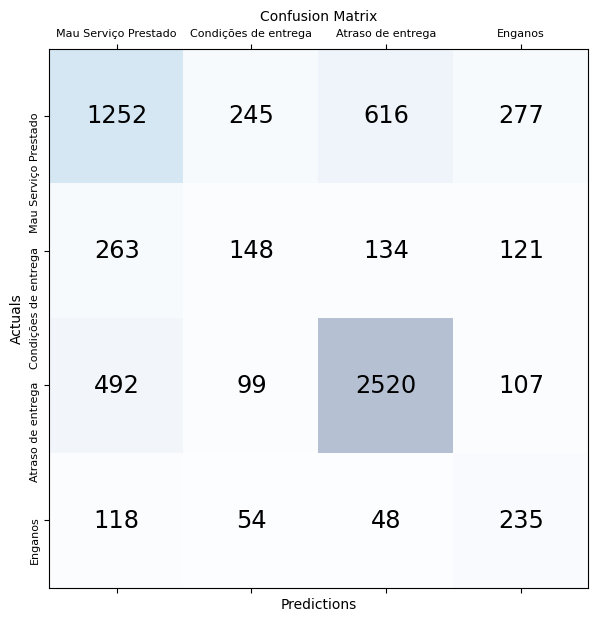



Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.52      0.55      2390
           1       0.27      0.22      0.24       666
           2       0.76      0.78      0.77      3218
           3       0.32      0.52      0.39       455

    accuracy                           0.62      6729
   macro avg       0.48      0.51      0.49      6729
weighted avg       0.62      0.62      0.62      6729



In [12]:
model= LinearSVC(class_weight='balanced', random_state=42)
pipeline = Pipeline([
    ('classifier', model)
])

pipeline.fit(X_train_embeddings, y_train)

class_labels = ['Mau Serviço Prestado', 'Condições de entrega', 'Atraso de entrega', 'Enganos']
# Predict on the test data
y_pred = pipeline.predict(X_test_embeddings)
# Plot the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(7, 7))
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i, s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)

# Customize the x and y axis tick labels
ax.set_xticklabels([''] + class_labels, fontsize=8)
ax.set_yticklabels([''] + class_labels, rotation=90,fontsize=8)
plt.show()
print('\n')

# Generate and print the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

[[1252  245  616  277]
 [ 263  148  134  121]
 [ 492   99 2520  107]
 [ 118   54   48  235]]


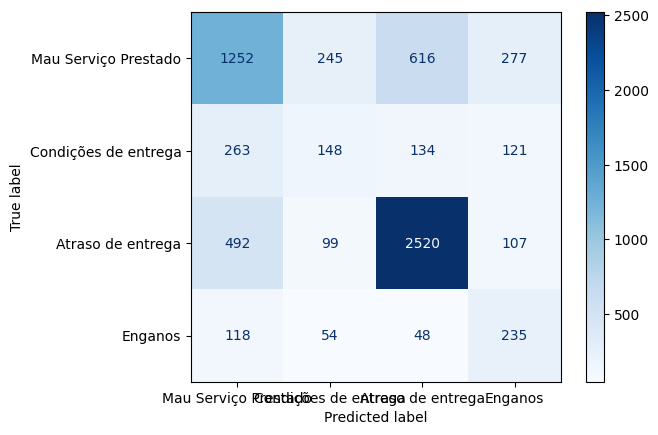

In [13]:
class_names = ['Mau Serviço Prestado', 'Condições de entrega', 'Atraso de entrega', 'Enganos']
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test_embeddings,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
    )

print(disp.confusion_matrix)

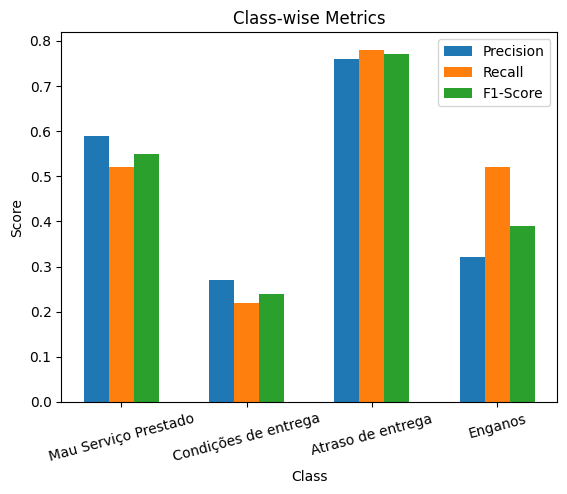

In [32]:
# Define your class names and class-wise metrics (e.g., precision, recall, F1-score)
class_names = ['Mau Serviço Prestado', 'Condições de entrega', 'Atraso de entrega', 'Enganos']
precision_scores = [0.59, 0.27, 0.76, 0.32]
recall_scores = [0.52, 0.22, 0.78, 0.52]
f1_scores = [0.55, 0.24, 0.77, 0.39]

# Create a figure and axis for the bar chart
fig, ax = plt.subplots()

# Set the width of the bars
bar_width = 0.2

# Create an array of equally spaced x-values for each class
x = range(len(class_names))

# Plot precision, recall, and F1-score as separate bars for each class
plt.bar(x, precision_scores, width=bar_width, label='Precision')
plt.bar([i + bar_width for i in x], recall_scores, width=bar_width, label='Recall')
plt.bar([i + 2 * bar_width for i in x], f1_scores, width=bar_width, label='F1-Score')

# Set the x-axis labels and class names
plt.xlabel('Class')
plt.xticks([i + bar_width for i in x], class_names, rotation=15)

# Set the y-axis label
plt.ylabel('Score')

# Add a legend
plt.legend()

# Set the title
plt.title('Class-wise Metrics')

# Show the plot
plt.show()

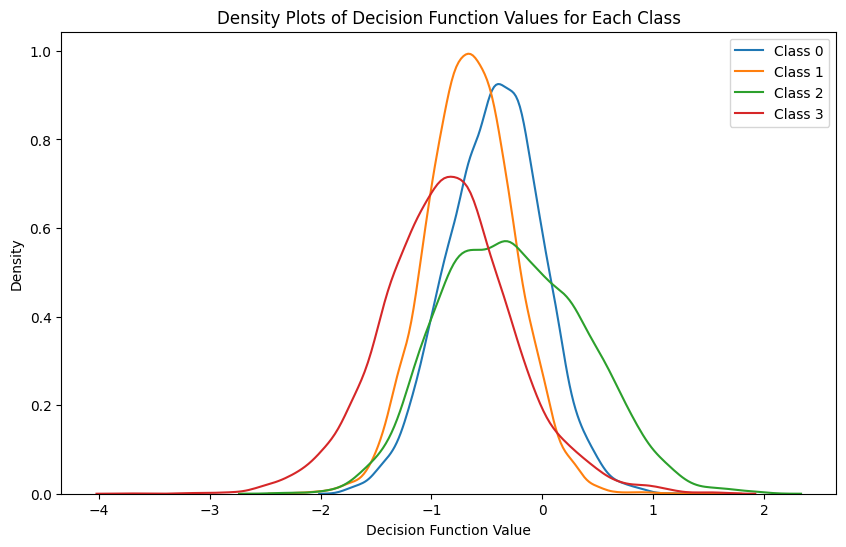

In [33]:
# Get decision function values for test data
decision_values = pipeline.decision_function(X_test_embeddings)
# Create a DataFrame for decision function values
df_decision = pd.DataFrame(data=decision_values, columns=[f'Class {i}' for i in range(decision_values.shape[1])])

# Create density plots for each class
plt.figure(figsize=(10, 6))
for class_label in df_decision.columns:
    sns.kdeplot(df_decision[class_label], label=class_label)

plt.xlabel('Decision Function Value')
plt.ylabel('Density')
plt.legend()
plt.title('Density Plots of Decision Function Values for Each Class')
plt.show()

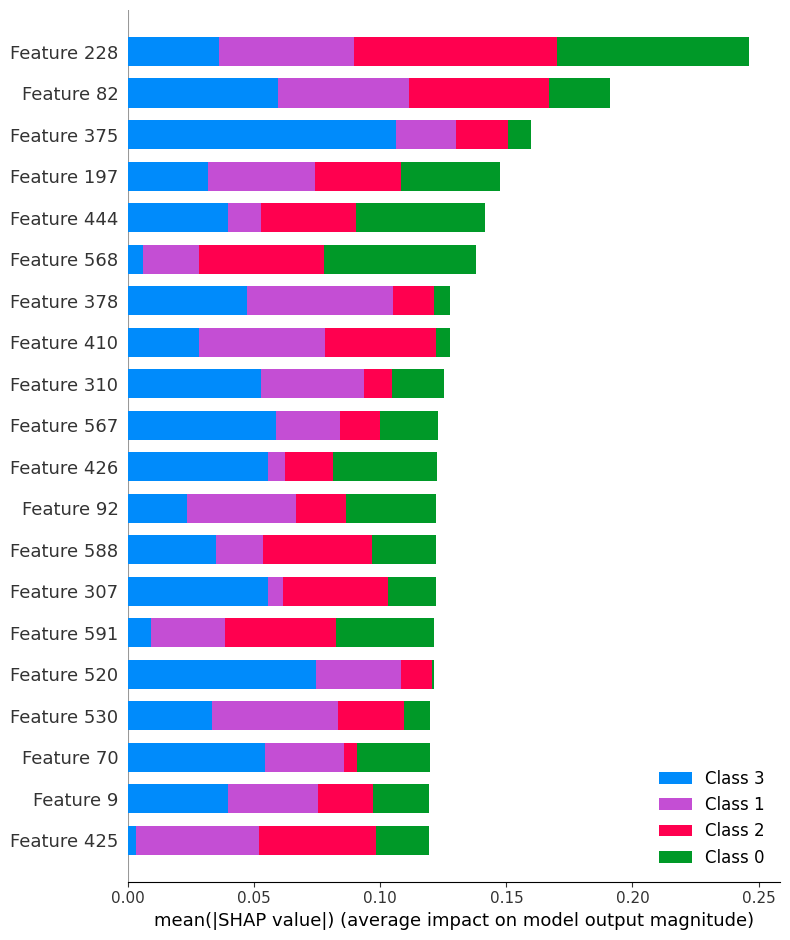

In [49]:
import shap

# Assuming you have a trained LinearSVC model
explainer = shap.LinearExplainer(model, X_train_embeddings)
shap_values = explainer.shap_values(X_test_embeddings)

# Summarize SHAP values for a specific prediction
shap.summary_plot(shap_values, X_test_embeddings)

# Error analysis

In [35]:
# Create a DataFrame to store misclassified examples
predictions_df = pd.DataFrame({'Original Text': X_test['description'], 'TFIDF Text': X_test_selected, 
                                 'Actual_Label': y_test, 'Predicted_Label': y_pred})
predictions_df['Actual_Label'] = predictions_df['Actual_Label'].replace({0: 'Mau Serviço Prestado', 
                                               1: 'Condições de entrega',
                                               2: 'Atraso de entrega',
                                               3: 'Enganos'})
predictions_df['Predicted_Label'] = predictions_df['Predicted_Label'].replace({0: 'Mau Serviço Prestado', 
                                               1: 'Condições de entrega',
                                               2: 'Atraso de entrega',
                                               3: 'Enganos'})

# Filter for misclassified examples
misclassified_df = predictions_df[predictions_df['Actual_Label'] != predictions_df['Predicted_Label']]
# Filter out correctly classified examples
correct_df=predictions_df[predictions_df['Actual_Label'] == predictions_df['Predicted_Label']]

In [23]:
print(random_sample_misclassified_msp.iloc[1]['Original Text'])

Bom dia,
Venho expressar o meu descontentamento com os vossos serviços. A minha encomenda com o número de seguimento RP862081964CN foi enviada no início de Dezembro 2019 e desde 21 de Janeiro de 2020 continua com o estado "Receção internacional". Após ter contactado várias vezes telefonicamente os vossos serviços foi aberto a reclamação com o número 20I19098 à qual ainda não recebi resposta. Até ao dia de hoje 6 de Março, continuo a aguardar a entrega da minha encomenda. Conclui-se portanto que a embalagem está perdida e nada fazem para resolver o assunto.


In [25]:
print(random_sample_misclassified_msp.iloc[4]['Original Text'])

Após consultar hoje (14-2-2022) a situação de encomenda proveniente do Reino Unido, constatei que a mesma se encontra sinalizada como entregue. Não recebi a encomenda, nem a mesma foi recebida no local de entrega até ao momento. Sendo que paguei a encomenda em 32,84 libras inglesas, e ainda paguei o processo de desalfandegamento em 11,62 euros, considero que estou a ser roubada. 
Infelizmente problemas com entregas são recorrentes no meu local de residência e de entrega de encomendas. Os CTT continuam a prestar um mau serviço.



**Actual label is “Mau Serviço Prestado” but classified as “Atraso de entrega”**

In [16]:
misclassified_msp = misclassified_df[(misclassified_df['Actual_Label'] == 'Mau Serviço Prestado') 
                                     & (misclassified_df['Predicted_Label'] == 'Atraso de entrega')]

random_sample_misclassified_msp = misclassified_msp.sample(n=150, random_state=42)  
for i in range(len(random_sample_misclassified_msp)):
    label=random_sample_misclassified_msp['Predicted_Label'].iloc[i]
    original=random_sample_misclassified_msp['Original Text'].iloc[i]
    print(f'THIS WAS CLASSIFIED AS {label}: \n ORIGINAL TEXT: {original} ')
    print('****************************************************************************')

THIS WAS CLASSIFIED AS Atraso de entrega: 
 ORIGINAL TEXT: Foi-me enviada no dia 5 de Outubro uma encomenda vinda dos USA (compra online através do paypal) pela USPS (número de registo da encomenda é LK069267241US). De acordo com o site desta empresa transportadora a minha encomenda chegou a Lisboa no dia 10 de Outubro encontrando-se em trânsito para o destino desde esse dia! No tracking dos CTT a encomenda não apresenta registos desde Chicago. Já contactei os CTT por email (Ticket #XKR8JY) e informaram-me que não têm conhecimento da minha encomenda e que nem esta se encontra cativa na alfândega. A encomenda têm seguro mas a USPS contactada pelo vendedor não aceita a reclamação já que, segundo eles, a encomenda chegou a Portugal sendo portanto já responsabilidade dos serviços aduaneiros. 
****************************************************************************
THIS WAS CLASSIFIED AS Atraso de entrega: 
 ORIGINAL TEXT: Bom dia,
Venho expressar o meu descontentamento com os vossos se

**Actual label is “Atraso de entrega” but classified as “Mau Serviço Prestado”**

In [17]:
misclassified_atrasos = misclassified_df[(misclassified_df['Actual_Label'] == 'Atraso de entrega') 
                                     & (misclassified_df['Predicted_Label'] == 'Mau Serviço Prestado')]

random_sample_misclassified_atrasos = misclassified_atrasos.sample(n=150, random_state=42)  
for i in range(len(random_sample_misclassified_atrasos)):
    label=random_sample_misclassified_atrasos['Predicted_Label'].iloc[i]
    original=random_sample_misclassified_atrasos['Original Text'].iloc[i]
    print(f'THIS WAS CLASSIFIED AS {label}: \n ORIGINAL TEXT: {original} ')
    print('****************************************************************************')

THIS WAS CLASSIFIED AS Mau Serviço Prestado: 
 ORIGINAL TEXT: No dia 17/05/2021 foi-me enviada uma encomenda de Inglaterra por um conhecido meu. Cerca de 2 semanas antes, tinha-me sido enviada uma encomenda em tudo idêntica, pela mesma pessoa e com o conteúdo muito parecido e tudo tinha corrido bem. Desta vez, e para tentar poupar um dinheiro, a encomenda foi enviada por correio normal. Pois, foi a pior coisa que podia ter feito (ainda estou a tentar perceber porquê)! Até hoje a encomenda não apareceu. Enviada pela mesma pessoa, da mesma morada e para a mesma morada ... e nada! Entrei em contacto com os CTT, de todas as formas (telefone e email) e ninguém me conseguiu ajudar nem sequer se mostraram minimamente recetivos ou preocupados em tentar resolver o problema! Compreendo que se estamos a falar de um serviço mais barato, possa demorar mais algum tempo, não haver forma de rastrear a encomenda e coisas desse género, agora ninguém se responsabilizar por um serviço que é vendido por el

**Actual label is “Condições de entrega” but classified as anything else**

In [18]:
misclassified_condicoes = misclassified_df[(misclassified_df['Actual_Label'] == 'Condições de entrega') 
                                     & (misclassified_df['Predicted_Label'] != 'Condições de entrega')]

random_sample_misclassified_condicoes = misclassified_condicoes.sample(n=150, random_state=42)  
for i in range(len(random_sample_misclassified_condicoes)):
    label=random_sample_misclassified_condicoes['Predicted_Label'].iloc[i]
    original=random_sample_misclassified_condicoes['Original Text'].iloc[i]
    print(f'THIS WAS CLASSIFIED AS {label}: \n ORIGINAL TEXT: {original} ')
    print('****************************************************************************')

THIS WAS CLASSIFIED AS Mau Serviço Prestado: 
 ORIGINAL TEXT: a entidade que &eacute; respons&aacute;vel pela distribui&ccedil;&atilde;o do correio registado, para n&atilde;o se dar ao trabalho de se deslocar ao 4&ordm; andar aonde resido para me entregar o correi ( alerto que sou um doente de alto riso e vivo sozinho, como pode comprovar o servi&ccedil;o de apoio da junta de freguesia de Canidelo ), vai pelo caminho que lhe &eacute; menos trabalhosa que &eacute; colocar um aviso no recept&aacute;culo para correio normal colocado &aacute; entrada do pr&eacute;dio.
 
****************************************************************************
THIS WAS CLASSIFIED AS Mau Serviço Prestado: 
 ORIGINAL TEXT: Venho por este meio solicitar o minimo de senso comum e respeito pela minha pessoa, NUNCA fiz uma reclamação contra nenhum serviço pois não sou dessas coisas mas com os CTT já estou no limite. 
Era suposto receber uma encomenda no dia 17/07/2019 e até hoje ainda não a recebi porque está 

In [36]:
#samples that are MSP class 0 but were classified as something else
condiçoes = correct_df[(correct_df['Actual_Label'] == 'Condições de entrega') 
                                     & (correct_df['Predicted_Label'] == 'Condições de entrega')]
for i in range(len(condiçoes)):
    label=condiçoes['Predicted_Label'].iloc[i]
    original=condiçoes['Original Text'].iloc[i]
    print(f'THIS WAS CLASSIFIED AS {label}: \n ORIGINAL TEXT: {original} ')
    print('****************************************************************************')

THIS WAS CLASSIFIED AS Condições de entrega: 
 ORIGINAL TEXT: Foi enviada um encomenda registada com o número acima descrito e foi detetada num outro local em cima de um banco e aberta.
Tenho na porta da minha loja, centro comercial Mayflower, um aviso ao carteiro para fazer entregas de encomendas na loja 41 ( envio em anexo a fotografia)
E essa mesma encomenda foi encontrada, fora do centro comercial, no inicio da rua António José de Almeida em cima de um banco e aberta. Dentro da mesma estavam dois colares, e foi roubado o mais caro!
Não percebo sendo registada porque é que não deixaram o registo para eu levantar ou porque não foram entregar na loja que eu indiquei na porta do meu estabelecimento 
****************************************************************************
THIS WAS CLASSIFIED AS Condições de entrega: 
 ORIGINAL TEXT: Fiz uma compra num site na Internet no dia 18/06/2018 que utiliza os CTT para fazer as entregas.
A empresa notificou-me a dizer que a encomenda seria en

**Actual label is “Enganos” but classified as anything else**

In [19]:
misclassified_enganos = misclassified_df[(misclassified_df['Actual_Label'] == 'Enganos') 
                                     & (misclassified_df['Predicted_Label'] != 'Enganos')]

random_sample_misclassified_enganos = misclassified_enganos.sample(n=150, random_state=42)  
for i in range(len(random_sample_misclassified_enganos)):
    label=random_sample_misclassified_enganos['Predicted_Label'].iloc[i]
    original=random_sample_misclassified_enganos['Original Text'].iloc[i]
    print(f'THIS WAS CLASSIFIED AS {label}: \n ORIGINAL TEXT: {original} ')
    print('****************************************************************************')

THIS WAS CLASSIFIED AS Condições de entrega: 
 ORIGINAL TEXT: Recebo muitas encomendas do estrangeiro. Trabalho na Escola de São Julião da Barra. O endereço que tenho de entrega é: 
Av. D. João I - Escola de S. Julião da Barra 2780-065 OEIRAS.
Pois as encomendas vão SEMPRE para a sede do Agrupamento (Liceu de Oeiras)! Está bem explícito o remetente, morada e código postal!
Algumas encomendas não me foram entregues! 
****************************************************************************
THIS WAS CLASSIFIED AS Mau Serviço Prestado: 
 ORIGINAL TEXT: No passado dia 13/10/2020, fui notificada de 2 cartas cujo remetente era o Tribunal, pedido o reencaminhamento de ambas que tinham sido avisadas com aviso de levantamento nos correios, veio a verificar-se que uma não tinha o mesmo destinatário ou que o destinatário estava errado.
Infelizmente só se verificou depois de ter aceite na nova morada e pago o valor que não quiseram devolver por já ter sido aceite.
Note-se: aceite correspondênci